In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, AdamW
from tensorflow.keras import regularizers, models, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
import wandb
import gc
import cv2

import os
import sqlite3

2026-02-22 00:54:01.819831: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-22 00:54:01.819922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-22 00:54:01.901601: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-22 00:54:02.081105: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.keras.backend.clear_session()

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("TensorFlow is using the GPU \n", gpus)
else:
    print("No GPU detected.")

TensorFlow is using the GPU 
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2026-02-22 00:54:12.181870: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-22 00:54:12.403237: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-22 00:54:12.406420: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
import wandb 

from wandb.integration.keras import WandbMetricsLogger

wandb.require("core")
wandb.login()

wandb: WARNING `wandb.require('core')` is a no-op as it is now the default behavior.
wandb: Currently logged in as: emmdaz (emmdaz-zzz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
# We create the dataframe for all the data subsets for training, test and validation
sg = pd.read_csv("/tf/Higgs-Boson-LHC-Collision-Detector/Datasets/Signal.csv")
bg = pd.read_csv("/tf/Higgs-Boson-LHC-Collision-Detector/Datasets/Background.csv")

sg_sample1 = sg.sample(frac = 0.5, random_state = 4)
sg_sample2 = sg.sample(frac = 0.3, random_state = 4)
sg_sample3 = sg.sample(frac = 0.2, random_state = 4)

bg_sample1 = bg.sample(frac = 0.5, random_state = 4)
bg_sample2 = bg.sample(frac = 0.3, random_state = 4)
bg_sample3 = bg.sample(frac = 0.2, random_state = 4)

train = pd.concat([sg_sample1, bg_sample1])
test = pd.concat([sg_sample2, bg_sample2])
val = pd.concat([sg_sample3, bg_sample3])

# Now we can create the subsets:
X_train, X_test, X_val = train.drop(columns = ["label"]), test.drop(columns = ["label"]), val.drop(columns = ["label"])
y_train, y_test, y_val = train["label"], test["label"], val["label"]

# And we stardardize the data:

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Check the sizes
print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 277081
Validation size: 110832
Test size: 166248


In [6]:
# For the trials we make a smaller train and test sets:

train_small = train.sample(frac = 0.05, random_state = 5)
test_small = test.sample(frac = 0.05, random_state = 5)

X_train_small, X_test_small = train_small.drop(columns = ["label"]), test_small.drop(columns = ["label"])
y_train_small, y_test_small = train_small["label"], test_small["label"]

X_train_small = scaler.fit_transform(X_train_small)
X_test_small = scaler.transform(X_test_small)

# Check the sizes
print("Train size:", len(X_train_small))
print("Test size:", len(X_test_small))

Train size: 13854
Test size: 8312


In [7]:
X_train_small.shape

(13854, 13)

In [8]:
# We define a function to create residual blocks (considering a layer regularizer L2)

def residual_block(x, n, activation, dropout, dropout_rate, regularizer, r_2):
        
    residual = x  
        
    if dropout == "y":
        # Main path
        x = layers.Dense(n, activation = activation, kernel_regularizer = regularizers.l2(r_2))(x)
        x = layers.BatchNormalization()(x)
        
        # Intermediate dropout layer
        x = layers.Dropout(dropout_rate)(x)
            
        # Linear layer
        x = layers.Dense(n, kernel_regularizer = regularizers.l2(r_2))(x)
        x = layers.BatchNormalization()(x)
            
    else: 
        # Main path
        x = layers.Dense(n, activation = activation, kernel_regularizer = regularizers.l2(r_2))(x)
        x = layers.BatchNormalization()(x)
            
        # Linear layer
        x = layers.Dense(n, kernel_regularizer = regularizers.l2(r_2))(x)
        x = layers.BatchNormalization()(x)

    # Project shortcut to same dimension
    residual = layers.Dense(n)(residual)

    # Conection residual sum
    x = layers.add([x, residual]) 
    x = layers.Activation(activation)(x)
        
    return x

In [9]:
# We create the function to start the study and optimizarion using Optuna
def objective(trial):

    tf.keras.backend.clear_session()

    inputs = layers.Input(shape = (X_train.shape[1],))
    
    #############################################################################################################
    
    # Optuna suggests activation function for all layers
    activation = trial.suggest_categorical("activation", ["relu", "relu6", "leaky_relu"])
    
    # Optuna suggests regularizer L2 value
    regularizer = "L2"
    r_2 = trial.suggest_float("regularizer_value_2", 1e-7, 1e-5, log = True)
    
    # Optuna suggest the number of layers
    n_layers = trial.suggest_int("N_layers", 15,20)
    
    # Optuna suggests learning rate value and an optimizer
    lr = trial.suggest_float("learning_rate", 2.5e-4, 1e-3, log = True)
    
    optimizer_name = trial.suggest_categorical("optimizer", ["sgd", "adam", "rmsprop", "adamw"])
                              
    if optimizer_name == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate = lr)
    elif optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    elif optimizer_name == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr)
    elif optimizer_name == "adamw":
        optimizer = tf.keras.optimizers.AdamW(learning_rate = lr)              
    
    #############################################################################################################
    
    # First layer

    # Optuna suggest number of neurons for the first layer

    N = trial.suggest_int("N_1st_layer", 128, 256)
    
    x = layers.Dense(N, input_shape = (X_train.shape[1],))(inputs)
    x = layers.Activation(activation)(x)
    x = layers.BatchNormalization()(x)
    
    # Optuna suggests neurons for the residual blocks and if using Dropout block
    
    dropout_per_layer = []
    dropout_percentage_per_layer = []
            
    dropping_out = trial.suggest_categorical("Dropout", ["y", "n"])

    N_per_layer = []
    
    for i in range(n_layers):
        
        n = trial.suggest_int(f"N_{i+1}_layer", 128, 256)
        N_per_layer.append(n)
                              
        dropout_rate = trial.suggest_float(f"Dropout_value_L{i+2}",0.1, 0.15)
        
        # i-th residual block:
        
        # Choosing between Dropout or a regulizer
        
        if dropping_out == "y":
            dropout_percentage_per_layer.append(dropout_rate)
            x = residual_block(x, n, activation, "y", dropout_rate, regularizer, r_2)

        else:
            dropout_percentage_per_layer.append(0.0)
            x = residual_block(x, n, activation, "n", dropout_rate, regularizer, r_2)            
            
    x = layers.Dropout(0.4)(x)  
    outputs = layers.Dense(1, activation = "sigmoid")(x)
    model = models.Model(inputs, outputs)
                              
    model.compile(optimizer = optimizer,
                  loss = "binary_crossentropy",
                  metrics = ["accuracy",
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.AUC(curve = "ROC"),
                             tf.keras.metrics.AUC(curve = "PR")])
    
    #############################################################################################################

    wandb.init(
        project = "Residual-SnB-Trials-3.0",
        name = f"Trial_{trial.number}",
        reinit = True,
        config = {
            "Units_1": N,
            "Units_per_layer": N_per_layer,
            "activation": activation,
            "n_layers": n_layers,
            "regularizer": regularizer,
            "r_value2": r_2,
            "Dropout": dropping_out, 
            "dropout_percentage_per_layer": dropout_percentage_per_layer,
            "learning_rate": lr,
            "optimizer": optimizer_name        }
    )
    
    #############################################################################################################
    
    """
    Callbacks
    """
    early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 7, restore_best_weights = True)
    lr_reduction = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 5)
#     tensorboard_cb = TensorBoard(log_dir = "/workspace/Optuna-Trials/Plant-Pathology-Classificator/tf_debug", histogram_freq = 1, write_graph = True,
#                                  write_images = False)
    
    #############################################################################################################
    
    """
    Creación del modelo
    """
    
    try:
        print(model.summary())
    
        history = model.fit(
            X_train_small, y_train_small,
            validation_data = (X_test_small, y_test_small),
            batch_size = 32,
            epochs = 200,
            verbose = 1, 
            callbacks = [WandbMetricsLogger(log_freq = 5), early_stopping, lr_reduction]
        )

        val_loss = min(history.history["val_loss"])
        val_accuracy = max(history.history["val_accuracy"])
        
        train_loss = min(history.history["loss"])
        train_accuracy = max(history.history["accuracy"])
    
    except tf.errors.ResourceExhaustedError as e:
        
        print(f"Intento {trial.number} falló debido a: {e}")
        
        tf.keras.backend.clear_session()
        wandb.finish()
        gc.collect()
        
        return float("inf")

    except Exception as e:
        
        print(f"Intento {trial.number} falló. Unexpected error: {e}")
        
        tf.keras.backend.clear_session()
        wandb.finish()
        gc.collect()
        
        return float("inf")
    
    # score = val_loss + 0.1 * (train_loss - val_loss)
    
    score = val_accuracy
    
    # score = train_loss 
    
    tf.keras.backend.clear_session()
    gc.collect()
    wandb.finish()

    return 1-score

In [ ]:
# study = optuna.create_study(
#     study_name = "Residual-Trials-2.0",
#     direction = "minimize",
#     storage = "sqlite:////workspace/Optuna-Trials/ResNet_SnB_study.db",
#     load_if_exists = True
# )

# study.optimize(objective, n_trials = 500)

[I 2026-02-21 20:03:28,564] A new study created in RDB with name: Residual-Trials-2.0
2026-02-21 20:03:28.643298: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-21 20:03:28.644189: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-21 20:03:28.644977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at htt

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 190)                  2660      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 190)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 190)                  760       ['activation[0][0]']          
 Normalization)                                                                               

2026-02-21 20:03:39.961716: I external/local_xla/xla/service/service.cc:168] XLA service 0x76d6604d0d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-21 20:03:39.961754: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2026-02-21 20:03:39.978350: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1771704220.016896  118601 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/433 [==============================] - 24s 27ms/step - loss: 0.3990 - accuracy: 0.8196 - precision: 0.8833 - auc: 0.8715 - auc_1: 0.9473 - val_loss: 0.1244 - val_accuracy: 0.9675 - val_precision: 0.9891 - val_auc: 0.9922 - val_auc_1: 0.9970 - lr: 8.5219e-04
Epoch 2/200
433/433 [==============================] - 11s 25ms/step - loss: 0.1601 - accuracy: 0.9441 - precision: 0.9649 - auc: 0.9798 - auc_1: 0.9926 - val_loss: 0.0690 - val_accuracy: 0.9811 - val_precision: 0.9873 - val_auc: 0.9944 - val_auc_1: 0.9971 - lr: 8.5219e-04
Epoch 3/200
433/433 [==============================] - 11s 25ms/step - loss: 0.1115 - accuracy: 0.9604 - precision: 0.9735 - auc: 0.9896 - auc_1: 0.9961 - val_loss: 0.0540 - val_accuracy: 0.9858 - val_precision: 0.9921 - val_auc: 0.9953 - val_auc_1: 0.9975 - lr: 8.5219e-04
Epoch 4/200
433/433 [==============================] - 12s 27ms/step - loss: 0.0934 - accuracy: 0.9693 - precision: 0.9802 - auc: 0.9917 - auc_1: 0.9966 - val_loss: 0.0410 - val_accuracy: 0.

batch/accuracy,▁▆▆▆▇▇▇▇▇▇▇█▇▇▇▇█▇████████▇█████████████
batch/auc,▁▆██████████████████████████████████████
batch/auc_1,▁███████████████████████████████████████
batch/batch_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,█████████████████████████████▂▂▂▂▂▂▂▂▂▂▁
batch/loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
batch/precision,▁▆▇█▇▇▇▇▇▇██▇███████████████████████████
epoch/accuracy,▁▆▇▇▇▇▇██████████████████
epoch/auc,▁▇▇██████████████████████
epoch/auc_1,▁▇███████████████████████
+9,...


[I 2026-02-21 20:08:29,459] Trial 0 finished with value: 0.0034889578819274902 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 2.3219212041219543e-07, 'N_layers': 15, 'learning_rate': 0.0008521881428684396, 'optimizer': 'sgd', 'N_1st_layer': 190, 'Dropout': 'n', 'N_1_layer': 245, 'Dropout_value_L2': 0.11357006886532212, 'N_2_layer': 195, 'Dropout_value_L3': 0.11574650063741099, 'N_3_layer': 220, 'Dropout_value_L4': 0.14250716627175578, 'N_4_layer': 178, 'Dropout_value_L5': 0.13725767036416064, 'N_5_layer': 237, 'Dropout_value_L6': 0.14983538271990812, 'N_6_layer': 245, 'Dropout_value_L7': 0.1005943687339103, 'N_7_layer': 244, 'Dropout_value_L8': 0.14764323397917606, 'N_8_layer': 157, 'Dropout_value_L9': 0.11263511497037355, 'N_9_layer': 167, 'Dropout_value_L10': 0.10321288880148391, 'N_10_layer': 247, 'Dropout_value_L11': 0.10676604072710591, 'N_11_layer': 198, 'Dropout_value_L12': 0.14756613019626225, 'N_12_layer': 174, 'Dropout_value_L13': 0.1011251954624054, 'N_1

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 251)                  3514      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 251)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 251)                  1004      ['activation[0][0]']          
 Normalization)                                                                               

2026-02-21 20:08:45.540485: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


433/433 [==============================] - 40s 36ms/step - loss: 0.2179 - accuracy: 0.9160 - precision: 0.9417 - auc: 0.9667 - auc_1: 0.9876 - val_loss: 0.0434 - val_accuracy: 0.9865 - val_precision: 0.9989 - val_auc: 0.9985 - val_auc_1: 0.9996 - lr: 4.8222e-04
Epoch 2/200
433/433 [==============================] - 15s 34ms/step - loss: 0.0806 - accuracy: 0.9716 - precision: 0.9850 - auc: 0.9945 - auc_1: 0.9979 - val_loss: 0.0325 - val_accuracy: 0.9913 - val_precision: 0.9992 - val_auc: 0.9994 - val_auc_1: 0.9998 - lr: 4.8222e-04
Epoch 3/200
433/433 [==============================] - 15s 34ms/step - loss: 0.0552 - accuracy: 0.9836 - precision: 0.9909 - auc: 0.9971 - auc_1: 0.9988 - val_loss: 0.0258 - val_accuracy: 0.9955 - val_precision: 0.9969 - val_auc: 0.9991 - val_auc_1: 0.9994 - lr: 4.8222e-04
Epoch 4/200
433/433 [==============================] - 15s 36ms/step - loss: 0.0461 - accuracy: 0.9869 - precision: 0.9927 - auc: 0.9975 - auc_1: 0.9989 - val_loss: 0.0149 - val_accuracy: 0.

batch/accuracy,▁▅▇▇▇▇▇▇▇███████████████████████████████
batch/auc,▁▇██████████████████████████████████████
batch/auc_1,▁▄▇█████████████████████████████████████
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇█████
batch/learning_rate,██████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁
batch/loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▂▂▅▇▇▇█████████████████████████████████
epoch/accuracy,▁▆▇▇▇▇▇▇████████████
epoch/auc,▁▇▇▇████████████████
epoch/auc_1,▁▇▇▇██▇█████████████
+9,...


[I 2026-02-21 20:13:53,326] Trial 1 finished with value: 0.001082777976989746 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 7.123602660610025e-07, 'N_layers': 19, 'learning_rate': 0.0004822224511751836, 'optimizer': 'adam', 'N_1st_layer': 251, 'Dropout': 'y', 'N_1_layer': 180, 'Dropout_value_L2': 0.10912226263309857, 'N_2_layer': 251, 'Dropout_value_L3': 0.12565903323370947, 'N_3_layer': 134, 'Dropout_value_L4': 0.14132694030987883, 'N_4_layer': 245, 'Dropout_value_L5': 0.11372831448016389, 'N_5_layer': 148, 'Dropout_value_L6': 0.14061693892615637, 'N_6_layer': 140, 'Dropout_value_L7': 0.10783750596224727, 'N_7_layer': 251, 'Dropout_value_L8': 0.14375516415168116, 'N_8_layer': 151, 'Dropout_value_L9': 0.1359590318244161, 'N_9_layer': 187, 'Dropout_value_L10': 0.14302974821527698, 'N_10_layer': 195, 'Dropout_value_L11': 0.12003140266979254, 'N_11_layer': 185, 'Dropout_value_L12': 0.1347413403305367, 'N_12_layer': 196, 'Dropout_value_L13': 0.10363570129622789, 'N_13

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 191)                  2674      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 191)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 191)                  764       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▁▁▂▂▂▆▄▅▆▆▄▆▇▇▇▇▇▇▇▇▇▇▇▆▇██████████████
batch/auc,▁▆▇▇▇▇█████████▇▇██████████▇████████████
batch/auc_1,▁▇██████████████████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████
batch/learning_rate,██████████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▂▂▂▂▂▂▂▁▁▂▃▂▂▂▃▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▅▇▇▇▇██████████████████████████████████
epoch/accuracy,▁▆▆▇▇▇▇▇█▇▇████████████████████
epoch/auc,▁▇▇▇███████████████████████████
epoch/auc_1,▁▇▇▇██████▇████████████████████
+9,...


[I 2026-02-21 20:22:14,614] Trial 2 finished with value: 0.0009624361991882324 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 2.145580233987612e-06, 'N_layers': 18, 'learning_rate': 0.00028292295863846853, 'optimizer': 'adamw', 'N_1st_layer': 191, 'Dropout': 'n', 'N_1_layer': 224, 'Dropout_value_L2': 0.1007889449385932, 'N_2_layer': 209, 'Dropout_value_L3': 0.10820158731984798, 'N_3_layer': 155, 'Dropout_value_L4': 0.11076669618529132, 'N_4_layer': 177, 'Dropout_value_L5': 0.1286620942129231, 'N_5_layer': 179, 'Dropout_value_L6': 0.10117973155324037, 'N_6_layer': 163, 'Dropout_value_L7': 0.12097866130053685, 'N_7_layer': 203, 'Dropout_value_L8': 0.11070861796364181, 'N_8_layer': 229, 'Dropout_value_L9': 0.1065451562188411, 'N_9_layer': 247, 'Dropout_value_L10': 0.10965106866911647, 'N_10_layer': 249, 'Dropout_value_L11': 0.10824907816139759, 'N_11_layer': 221, 'Dropout_value_L12': 0.1295413970549907, 'N_12_layer': 190, 'Dropout_value_L13': 0.13661185278583682, 'N_1

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 142)                  1988      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 142)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 142)                  568       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇████████████████████
batch/auc,▁▁▁▁▂▇▇▇▇▇▇▇████████████████████████████
batch/auc_1,▁▁▃▃▅▇▇▇▇▇█▇████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
batch/learning_rate,█████████████████████████████████▂▂▂▂▂▂▁
batch/loss,██▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▁▁▂▂▄▅▆▆▆▆▇▇▇▇▇████████████████████████
epoch/accuracy,▁▂▃▄▅▆▆▇▇▇▇▇▇▇██████████████
epoch/auc,▁▃▅▆▇▇▇█████████████████████
epoch/auc_1,▁▃▆▇▇▇██████████████████████
+9,...


[I 2026-02-21 20:30:16,009] Trial 3 finished with value: 0.008421540260314941 and parameters: {'activation': 'relu', 'regularizer_value_2': 2.0400060542001222e-06, 'N_layers': 19, 'learning_rate': 0.00025731055079631824, 'optimizer': 'adamw', 'N_1st_layer': 142, 'Dropout': 'n', 'N_1_layer': 214, 'Dropout_value_L2': 0.135376578362535, 'N_2_layer': 187, 'Dropout_value_L3': 0.1440696192658407, 'N_3_layer': 178, 'Dropout_value_L4': 0.13744846496618793, 'N_4_layer': 143, 'Dropout_value_L5': 0.14128078843033143, 'N_5_layer': 171, 'Dropout_value_L6': 0.105458651112775, 'N_6_layer': 172, 'Dropout_value_L7': 0.10376387947020038, 'N_7_layer': 208, 'Dropout_value_L8': 0.11970993447241801, 'N_8_layer': 238, 'Dropout_value_L9': 0.11743413168452549, 'N_9_layer': 217, 'Dropout_value_L10': 0.11803392908909342, 'N_10_layer': 155, 'Dropout_value_L11': 0.13016638839794367, 'N_11_layer': 151, 'Dropout_value_L12': 0.1439321554306722, 'N_12_layer': 243, 'Dropout_value_L13': 0.13856637878993353, 'N_13_layer'

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 153)                  2142      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 153)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 153)                  612       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▁▃▃▃▅▅▅▅▆▆▆▆▅▆▇▇▇█▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇██▇█
batch/auc,▁▇▇█████████████████████████████████████
batch/auc_1,▁▄▇█████████████████████████████████████
batch/batch_step,▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
batch/learning_rate,█████████████████████████████████████▁▁▁
batch/loss,█▆▃▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▁▃▆▆▇▇▇▇▇██▇████▇██████████████████████
epoch/accuracy,▁▆▆▇▇▇▇▇▇▇▇████████████████████████
epoch/auc,▁▇▇▇███████████████████████████████
epoch/auc_1,▁▇▇████████████████████████████████
+9,...


[I 2026-02-21 20:38:56,209] Trial 4 finished with value: 0.0038498640060424805 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 1.8281224165642945e-06, 'N_layers': 20, 'learning_rate': 0.0008267756130954013, 'optimizer': 'sgd', 'N_1st_layer': 153, 'Dropout': 'n', 'N_1_layer': 149, 'Dropout_value_L2': 0.11509868730024535, 'N_2_layer': 130, 'Dropout_value_L3': 0.1394733605887079, 'N_3_layer': 240, 'Dropout_value_L4': 0.1250897589161853, 'N_4_layer': 218, 'Dropout_value_L5': 0.11573739316874931, 'N_5_layer': 136, 'Dropout_value_L6': 0.14802879202635538, 'N_6_layer': 207, 'Dropout_value_L7': 0.13683490179963143, 'N_7_layer': 222, 'Dropout_value_L8': 0.1156997692398193, 'N_8_layer': 208, 'Dropout_value_L9': 0.11454493493011786, 'N_9_layer': 183, 'Dropout_value_L10': 0.14603484468760686, 'N_10_layer': 181, 'Dropout_value_L11': 0.1430528917158183, 'N_11_layer': 134, 'Dropout_value_L12': 0.12088690407861624, 'N_12_layer': 236, 'Dropout_value_L13': 0.13546273468087883, 'N_13_

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 128)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 128)                  512       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▇▇█████████████████████████████████████
batch/auc,▁▁▃▅▅▆█▆▇▇█▇████▇▇▇▇▇██▇██▇█▇███████████
batch/auc_1,▁▇██████████████████████████████████████
batch/batch_step,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇█████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▂▂▄█▇▇▇▇▇██████████████████████████████
epoch/accuracy,▁▆▇▇▇▇███████████████████
epoch/auc,▁▇▇▇█████████████████████
epoch/auc_1,▁▆▇▇█████████████████████
+9,...


[I 2026-02-21 20:45:51,303] Trial 5 finished with value: 0.001323401927947998 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 7.092753074505691e-06, 'N_layers': 18, 'learning_rate': 0.0003806160463985921, 'optimizer': 'adamw', 'N_1st_layer': 128, 'Dropout': 'y', 'N_1_layer': 156, 'Dropout_value_L2': 0.14484211768901162, 'N_2_layer': 172, 'Dropout_value_L3': 0.12873563336673097, 'N_3_layer': 191, 'Dropout_value_L4': 0.11172164105255991, 'N_4_layer': 142, 'Dropout_value_L5': 0.1470122982810702, 'N_5_layer': 128, 'Dropout_value_L6': 0.12641695485340065, 'N_6_layer': 225, 'Dropout_value_L7': 0.12464475866083621, 'N_7_layer': 184, 'Dropout_value_L8': 0.13451925338557358, 'N_8_layer': 221, 'Dropout_value_L9': 0.14811661145464533, 'N_9_layer': 207, 'Dropout_value_L10': 0.11926707017497132, 'N_10_layer': 176, 'Dropout_value_L11': 0.11758667330651973, 'N_11_layer': 177, 'Dropout_value_L12': 0.11263521711793362, 'N_12_layer': 243, 'Dropout_value_L13': 0.14989334618351535, 'N_

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 204)                  2856      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 204)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 204)                  816       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▄▁▁▁▂▄▅▅▅▅▅▅▅▅▃▅▆▆▇▆▆▆▇██▇███████████▇██
batch/auc,▁▇▇█████████████████████████████████████
batch/auc_1,▁▂▄█████████████████████████████████████
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇█
batch/learning_rate,████████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
batch/loss,█▅▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▁▇████▇█████████████▇██████████████████
epoch/accuracy,▁▆▇▇▇▇▇▇▇▇▇▇███████████
epoch/auc,▁▇▇█▇▇█▇▇▇▇▇███████████
epoch/auc_1,▁▇▇▇▇▇█▇▇▇▇▇███████████
+9,...


[I 2026-02-21 20:50:37,170] Trial 6 finished with value: 0.0028873682022094727 and parameters: {'activation': 'relu6', 'regularizer_value_2': 1.8887871529051904e-06, 'N_layers': 16, 'learning_rate': 0.0005965053426322108, 'optimizer': 'rmsprop', 'N_1st_layer': 204, 'Dropout': 'n', 'N_1_layer': 228, 'Dropout_value_L2': 0.11658670897203992, 'N_2_layer': 135, 'Dropout_value_L3': 0.1147060570360962, 'N_3_layer': 144, 'Dropout_value_L4': 0.12507642374934358, 'N_4_layer': 210, 'Dropout_value_L5': 0.1357039631172834, 'N_5_layer': 177, 'Dropout_value_L6': 0.14951543366868328, 'N_6_layer': 240, 'Dropout_value_L7': 0.11130464510021161, 'N_7_layer': 209, 'Dropout_value_L8': 0.1105979104661157, 'N_8_layer': 136, 'Dropout_value_L9': 0.10835020842449028, 'N_9_layer': 131, 'Dropout_value_L10': 0.1276886808928921, 'N_10_layer': 244, 'Dropout_value_L11': 0.1329350112424195, 'N_11_layer': 173, 'Dropout_value_L12': 0.14055041098247448, 'N_12_layer': 177, 'Dropout_value_L13': 0.11692563458489667, 'N_13_la

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 193)                  2702      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 193)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 193)                  772       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇████████████████████
batch/auc,▁▃▃▇▇▇▇████████████▇██▇█████████████████
batch/auc_1,▁▅██████████████████████████████████████
batch/batch_step,▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
batch/learning_rate,████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▄▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▃▅▅▅▆▂▅▆▆▆▇▇▇▆▅▆▆████▇████▇▇▇██████████
epoch/accuracy,▁▆▆▇▇▇▇▇▇█▇▇▇████████████████
epoch/auc,▁▇▇██████████████████████████
epoch/auc_1,▁▇▇▇███▇█████████████████████
+9,...


[I 2026-02-21 20:57:23,271] Trial 7 finished with value: 0.0018045902252197266 and parameters: {'activation': 'relu6', 'regularizer_value_2': 2.1721864104591645e-06, 'N_layers': 15, 'learning_rate': 0.0009519425858566402, 'optimizer': 'adamw', 'N_1st_layer': 193, 'Dropout': 'n', 'N_1_layer': 243, 'Dropout_value_L2': 0.1029608924817407, 'N_2_layer': 144, 'Dropout_value_L3': 0.13126745705775422, 'N_3_layer': 242, 'Dropout_value_L4': 0.11186084027879978, 'N_4_layer': 133, 'Dropout_value_L5': 0.11301989757357203, 'N_5_layer': 139, 'Dropout_value_L6': 0.14285757956712872, 'N_6_layer': 146, 'Dropout_value_L7': 0.14914494335874534, 'N_7_layer': 205, 'Dropout_value_L8': 0.13967899167773526, 'N_8_layer': 221, 'Dropout_value_L9': 0.12403822350744158, 'N_9_layer': 256, 'Dropout_value_L10': 0.14816555897438916, 'N_10_layer': 194, 'Dropout_value_L11': 0.13766611437020118, 'N_11_layer': 147, 'Dropout_value_L12': 0.11628357271670708, 'N_12_layer': 243, 'Dropout_value_L13': 0.11122250255001459, 'N_13_

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 222)                  3108      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 222)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 222)                  888       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▂▅▇▇▇█▇████████████████████████████████
batch/auc,▁▂▅▇▇▇██▇██████████▇██▇█████████████████
batch/auc_1,▁▃▄▄▅▆▆███▇██████████████▇██████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▄▃▃▂▂▃▂▂▄▃▁▂▂▂▂▂▂▂▂▂▂▄▂▂▁▂▂▂▂▂▁▂▁▂▂▁▁▂
batch/precision,▁▂▅▇▇▇▇███▇██████████▇██████████████████
epoch/accuracy,▁▇▇▇███▇██████
epoch/auc,▁▇█▇███▇██▇███
epoch/auc_1,▁▇▇▇███▆██▇███
+9,...


[I 2026-02-21 21:00:43,191] Trial 8 finished with value: 0.0014436841011047363 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 3.570426252621676e-07, 'N_layers': 17, 'learning_rate': 0.000908070148603559, 'optimizer': 'rmsprop', 'N_1st_layer': 222, 'Dropout': 'y', 'N_1_layer': 166, 'Dropout_value_L2': 0.1318771111955611, 'N_2_layer': 192, 'Dropout_value_L3': 0.14052074593478286, 'N_3_layer': 179, 'Dropout_value_L4': 0.10396017985419057, 'N_4_layer': 238, 'Dropout_value_L5': 0.10637250946324824, 'N_5_layer': 237, 'Dropout_value_L6': 0.13903710902702093, 'N_6_layer': 200, 'Dropout_value_L7': 0.13892130017114063, 'N_7_layer': 177, 'Dropout_value_L8': 0.14609933543890372, 'N_8_layer': 168, 'Dropout_value_L9': 0.11726072088515437, 'N_9_layer': 196, 'Dropout_value_L10': 0.11554706860186151, 'N_10_layer': 192, 'Dropout_value_L11': 0.12775615837575546, 'N_11_layer': 153, 'Dropout_value_L12': 0.11089166232065399, 'N_12_layer': 151, 'Dropout_value_L13': 0.12511205360422328, '

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 229)                  3206      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 229)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 229)                  916       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▃▃▄▄▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇████████████▇████
batch/auc,▁▄▅▇▇███████▇████████████████████▇▇▇████
batch/auc_1,▁▅▆▇▆███▆▇▇█▇▇▇████████▇██▇█▇▇▇█▇█▄▇████
batch/batch_step,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▂▁▁▁
batch/precision,▁▅▆█▇▇▇▇████████████████████████▇▇▇█████
epoch/accuracy,▁▆▇▇▇███▇█▅▆█
epoch/auc,▁▆█▇▇█████▄▇█
epoch/auc_1,▁▇█▇▇█████▄▇█
+9,...


[I 2026-02-21 21:04:01,973] Trial 9 finished with value: 0.0016843080520629883 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 8.712220486692574e-07, 'N_layers': 17, 'learning_rate': 0.0008925044108826185, 'optimizer': 'adam', 'N_1st_layer': 229, 'Dropout': 'n', 'N_1_layer': 159, 'Dropout_value_L2': 0.10640980080668411, 'N_2_layer': 199, 'Dropout_value_L3': 0.12328148003923695, 'N_3_layer': 179, 'Dropout_value_L4': 0.1121286917857937, 'N_4_layer': 211, 'Dropout_value_L5': 0.13632477245225139, 'N_5_layer': 224, 'Dropout_value_L6': 0.14108647865859947, 'N_6_layer': 220, 'Dropout_value_L7': 0.10773224471096952, 'N_7_layer': 231, 'Dropout_value_L8': 0.11749455894360597, 'N_8_layer': 181, 'Dropout_value_L9': 0.11994819849997623, 'N_9_layer': 234, 'Dropout_value_L10': 0.12394403002069833, 'N_10_layer': 159, 'Dropout_value_L11': 0.10247320583193441, 'N_11_layer': 157, 'Dropout_value_L12': 0.14140262183631883, 'N_12_layer': 238, 'Dropout_value_L13': 0.14012853206636824, 'N_

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 170)                  2380      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 170)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 170)                  680       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▂▃▄▄▅▆▆▆▆▆▇▇▇▇▇█▇█▇████████████████████
batch/auc,▁▅▇▇▇███████████████████████████████████
batch/auc_1,▁▆▆▆▆▇██████████████████████████████████
batch/batch_step,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███
batch/learning_rate,████████████████████████████████▂▂▂▁▁▁▁▁
batch/loss,█▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▁▁▅▆▇▇▇▇███████████████████████████████
epoch/accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇███████████████████████████
epoch/auc,▁▅▆▇▇███████████████████████████████████
epoch/auc_1,▁▄▆▇████████████████████████████████████
+9,...


[I 2026-02-21 21:17:36,850] Trial 10 finished with value: 0.0022858381271362305 and parameters: {'activation': 'relu', 'regularizer_value_2': 8.748652043256141e-06, 'N_layers': 18, 'learning_rate': 0.0002666596847576036, 'optimizer': 'adamw', 'N_1st_layer': 170, 'Dropout': 'y', 'N_1_layer': 203, 'Dropout_value_L2': 0.12589563848145996, 'N_2_layer': 232, 'Dropout_value_L3': 0.10073641412595252, 'N_3_layer': 149, 'Dropout_value_L4': 0.10387058795642379, 'N_4_layer': 175, 'Dropout_value_L5': 0.12694675155014962, 'N_5_layer': 204, 'Dropout_value_L6': 0.10060035608825345, 'N_6_layer': 170, 'Dropout_value_L7': 0.12048456297210806, 'N_7_layer': 142, 'Dropout_value_L8': 0.10000640789096893, 'N_8_layer': 250, 'Dropout_value_L9': 0.13409706512354147, 'N_9_layer': 253, 'Dropout_value_L10': 0.10002827530450226, 'N_10_layer': 231, 'Dropout_value_L11': 0.11255808587358018, 'N_11_layer': 237, 'Dropout_value_L12': 0.1292107173133888, 'N_12_layer': 206, 'Dropout_value_L13': 0.12692225772499735, 'N_13_l

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 249)                  3486      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 249)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 249)                  996       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▇▇█████████████████████████████████████
batch/auc,▁▅██████████████████████████████████████
batch/auc_1,▁▇██████████████████████████████████████
batch/batch_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
batch/learning_rate,██████████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
batch/loss,█▆▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▃▄▇▇███████████████████████████████████
epoch/accuracy,▁▆▇▇▇▇▇██████████████████████████
epoch/auc,▁▇▇▇█████████████████████████████
epoch/auc_1,▁▇▇▇█████████████████████████████
+9,...


[I 2026-02-21 21:26:40,982] Trial 11 finished with value: 0.0007218718528747559 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 1.0108539752809576e-07, 'N_layers': 20, 'learning_rate': 0.0003934805412969554, 'optimizer': 'adam', 'N_1st_layer': 249, 'Dropout': 'y', 'N_1_layer': 186, 'Dropout_value_L2': 0.10149869767898043, 'N_2_layer': 248, 'Dropout_value_L3': 0.1002273982287954, 'N_3_layer': 131, 'Dropout_value_L4': 0.1343132462950538, 'N_4_layer': 251, 'Dropout_value_L5': 0.1234544194787662, 'N_5_layer': 164, 'Dropout_value_L6': 0.1143024888978705, 'N_6_layer': 135, 'Dropout_value_L7': 0.11696438424062783, 'N_7_layer': 256, 'Dropout_value_L8': 0.13001195979484764, 'N_8_layer': 128, 'Dropout_value_L9': 0.1021149661252646, 'N_9_layer': 161, 'Dropout_value_L10': 0.13312286545562502, 'N_10_layer': 128, 'Dropout_value_L11': 0.11938418556399881, 'N_11_layer': 218, 'Dropout_value_L12': 0.13114467512345016, 'N_12_layer': 204, 'Dropout_value_L13': 0.10144449614519596, 'N_13

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  3584      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 256)                  1024      ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▁▄▇▇▇▇█████████████████████████████████
batch/auc,▁▇▇█████████████████████████████████████
batch/auc_1,▁▇▇█████████████████████████████████████
batch/batch_step,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇███
batch/learning_rate,██████████████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▂▃▃▃▅▅▅▆▆▆▇▇▇██████▇██▇████████████████
epoch/accuracy,▁▆▇▇▇▇█▇██████████████████████
epoch/auc,▁▇▇███████████████████████████
epoch/auc_1,▁▇▇███████████████████████████
+9,...


[I 2026-02-21 21:34:57,897] Trial 12 finished with value: 0.0006015300750732422 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 1.144488285318771e-07, 'N_layers': 20, 'learning_rate': 0.0003461658196175712, 'optimizer': 'adam', 'N_1st_layer': 256, 'Dropout': 'y', 'N_1_layer': 131, 'Dropout_value_L2': 0.10170626962410606, 'N_2_layer': 227, 'Dropout_value_L3': 0.10024608661450506, 'N_3_layer': 159, 'Dropout_value_L4': 0.13243339565958895, 'N_4_layer': 166, 'Dropout_value_L5': 0.12533365363455753, 'N_5_layer': 166, 'Dropout_value_L6': 0.11163151223155536, 'N_6_layer': 128, 'Dropout_value_L7': 0.11676285644022426, 'N_7_layer': 158, 'Dropout_value_L8': 0.13122842913740496, 'N_8_layer': 129, 'Dropout_value_L9': 0.10505561300409631, 'N_9_layer': 151, 'Dropout_value_L10': 0.1347243210408206, 'N_10_layer': 132, 'Dropout_value_L11': 0.10975716306406427, 'N_11_layer': 219, 'Dropout_value_L12': 0.1011326688864358, 'N_12_layer': 213, 'Dropout_value_L13': 0.11465936274670296, 'N_

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 244)                  3416      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 244)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 244)                  976       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▂▃▃▄▆▆▆▆▆▆▆▇▇▇▇▇▇██████████████████████
batch/auc,▁▃▃▇▇███████████████████████████████████
batch/auc_1,▁▁▂▃▃▅▆▇▇███████████████████████████████
batch/batch_step,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
batch/learning_rate,█████████████████████████████████▁▁▁▁▁▁▁
batch/loss,█▇▇▇▇▅▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▁▂▃▅▇▇▇▇▇▇█▇███████████████████████████
epoch/accuracy,▁▂▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇███████████████████████
epoch/auc,▁▁▃▅▆▇▇▇████████████████████████████████
epoch/auc_1,▁▂▃▅▆▇▇█████████████████████████████████
+9,...


[I 2026-02-21 21:46:14,210] Trial 13 finished with value: 0.001323401927947998 and parameters: {'activation': 'relu', 'regularizer_value_2': 1.0794779382314835e-07, 'N_layers': 20, 'learning_rate': 0.00035785178680835324, 'optimizer': 'adam', 'N_1st_layer': 244, 'Dropout': 'y', 'N_1_layer': 133, 'Dropout_value_L2': 0.12125499075166862, 'N_2_layer': 256, 'Dropout_value_L3': 0.10043469170618813, 'N_3_layer': 132, 'Dropout_value_L4': 0.1333441521540224, 'N_4_layer': 164, 'Dropout_value_L5': 0.1216479876112089, 'N_5_layer': 160, 'Dropout_value_L6': 0.11874239599078405, 'N_6_layer': 129, 'Dropout_value_L7': 0.11515362065869203, 'N_7_layer': 149, 'Dropout_value_L8': 0.130514192476125, 'N_8_layer': 135, 'Dropout_value_L9': 0.10009472580292424, 'N_9_layer': 143, 'Dropout_value_L10': 0.13615486161962678, 'N_10_layer': 129, 'Dropout_value_L11': 0.12101519440085849, 'N_11_layer': 256, 'Dropout_value_L12': 0.10016166935125459, 'N_12_layer': 221, 'Dropout_value_L13': 0.11208548803641716, 'N_13_laye

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 255)                  3570      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 255)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 255)                  1020      ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▁▆▆▇▇▇▇▇▇▇▇▇▇█▇▇███████████████████████
batch/auc,▁▆▆▇████████████████████████████████████
batch/auc_1,▁▁▇█████████████████████████████████████
batch/batch_step,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
batch/learning_rate,██████████████████████████████████████▁▁
batch/loss,█▇▆▅▅▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▄▄▅▇▇█▇▇▇██████████████████████████████
epoch/accuracy,▁▆▆▇▇▇▇██████████
epoch/auc,▁▇▇██████████████
epoch/auc_1,▁▇▇██████████████
+9,...


[I 2026-02-21 21:51:09,582] Trial 14 finished with value: 0.0018045902252197266 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 1.0009319833972791e-07, 'N_layers': 20, 'learning_rate': 0.0003721122923519444, 'optimizer': 'adam', 'N_1st_layer': 255, 'Dropout': 'y', 'N_1_layer': 187, 'Dropout_value_L2': 0.10011839497881897, 'N_2_layer': 230, 'Dropout_value_L3': 0.10858534869154239, 'N_3_layer': 161, 'Dropout_value_L4': 0.14874609998652405, 'N_4_layer': 196, 'Dropout_value_L5': 0.12123962721845033, 'N_5_layer': 198, 'Dropout_value_L6': 0.11415274327676325, 'N_6_layer': 153, 'Dropout_value_L7': 0.13168835430458306, 'N_7_layer': 164, 'Dropout_value_L8': 0.12769611443808626, 'N_8_layer': 132, 'Dropout_value_L9': 0.10027762910791556, 'N_9_layer': 161, 'Dropout_value_L10': 0.1328361561993046, 'N_10_layer': 129, 'Dropout_value_L11': 0.11365857831594507, 'N_11_layer': 211, 'Dropout_value_L12': 0.10034932476463627, 'N_12_layer': 216, 'Dropout_value_L13': 0.10838514403805163, '

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 232)                  3248      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 232)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 232)                  928       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▁▂▆▆▆▆▇▇▇██▇▇▇█████████████████████████
batch/auc,▁▁▅▆▇▇▇▇▇▇██████████████████████████████
batch/auc_1,▁▂▅▆▅▆▇▇▆▇▇▇▇▇▇▇▇███████████████████████
batch/batch_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇███
batch/learning_rate,█████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
batch/loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▆▆▆▆▆▇▇▇▇▇█████████████████████████████
epoch/accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇█▇████████████████████████
epoch/auc,▁▆▇▇▇██████████████████████████████████
epoch/auc_1,▁▇▇████████████████████████████████████
+9,...


[I 2026-02-21 22:01:30,054] Trial 15 finished with value: 0.00156402587890625 and parameters: {'activation': 'relu6', 'regularizer_value_2': 1.8042198379253428e-07, 'N_layers': 19, 'learning_rate': 0.0004909250373060727, 'optimizer': 'adam', 'N_1st_layer': 232, 'Dropout': 'y', 'N_1_layer': 135, 'Dropout_value_L2': 0.10921606009584389, 'N_2_layer': 230, 'Dropout_value_L3': 0.10712984998608353, 'N_3_layer': 213, 'Dropout_value_L4': 0.13153099612910998, 'N_4_layer': 256, 'Dropout_value_L5': 0.1306204406156545, 'N_5_layer': 157, 'Dropout_value_L6': 0.11244503752450427, 'N_6_layer': 128, 'Dropout_value_L7': 0.11607620166858403, 'N_7_layer': 163, 'Dropout_value_L8': 0.13505164321220142, 'N_8_layer': 185, 'Dropout_value_L9': 0.10638141260108454, 'N_9_layer': 158, 'Dropout_value_L10': 0.1382050941439874, 'N_10_layer': 146, 'Dropout_value_L11': 0.10190357896713594, 'N_11_layer': 230, 'Dropout_value_L12': 0.12310234705346844, 'N_12_layer': 128, 'Dropout_value_L13': 0.11759597041370282, 'N_13_lay

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 217)                  3038      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 217)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 217)                  868       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▅▇▇▇▇██████████████████████████████████
batch/auc,▁▃▅▇▇▇▇█████████████████████████████████
batch/auc_1,▁▂▇█████████████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇█████
batch/learning_rate,█████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
batch/loss,█▇▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▁▃▅▅▆▆▆▆▄▇▇▇▇▇▇▇▇▅▆▇█▇█▇▇▇▇████████████
epoch/accuracy,▁▆▇▇▇▇███████████████████████
epoch/auc,▁▇▇██████████████████████████
epoch/auc_1,▁▇▇██████████████████████████
+9,...


[I 2026-02-21 22:09:36,011] Trial 16 finished with value: 0.0008421540260314941 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 4.2023059532847275e-07, 'N_layers': 20, 'learning_rate': 0.0003236842010733878, 'optimizer': 'adam', 'N_1st_layer': 217, 'Dropout': 'y', 'N_1_layer': 173, 'Dropout_value_L2': 0.12345222498666639, 'N_2_layer': 215, 'Dropout_value_L3': 0.11647118347357341, 'N_3_layer': 128, 'Dropout_value_L4': 0.11909209376955297, 'N_4_layer': 161, 'Dropout_value_L5': 0.10775496711103351, 'N_5_layer': 212, 'Dropout_value_L6': 0.1291308957027502, 'N_6_layer': 173, 'Dropout_value_L7': 0.12917360804151673, 'N_7_layer': 136, 'Dropout_value_L8': 0.12335273603567573, 'N_8_layer': 151, 'Dropout_value_L9': 0.13138853960625294, 'N_9_layer': 144, 'Dropout_value_L10': 0.12804295598002288, 'N_10_layer': 142, 'Dropout_value_L11': 0.1124145965105016, 'N_11_layer': 207, 'Dropout_value_L12': 0.1053530824895696, 'N_12_layer': 221, 'Dropout_value_L13': 0.11894691965269676, 'N_

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 241)                  3374      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 241)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 241)                  964       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▇▇▇▇▇▇▇▇███████████████████████████████
batch/auc,▁▇▇▇▇███████████████████████████████████
batch/auc_1,▁▄▅▇▇▆▇▇█▇▇▇▇▇▇▆▇▇▇▇████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
batch/learning_rate,██████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁
batch/loss,█▃▃▃▂▂▂▂▁▂▂▂▁▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▇▇▇▇███████████████████████████████████
epoch/accuracy,▁▆▇▇▇▇▇█████▇████████████████
epoch/auc,▁▇▇██████████████████████████
epoch/auc_1,▁▇▇██████████████████████████
+9,...


[I 2026-02-21 22:17:23,605] Trial 17 finished with value: 0.0008421540260314941 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 1.7995924194225984e-07, 'N_layers': 19, 'learning_rate': 0.000429209750524592, 'optimizer': 'adam', 'N_1st_layer': 241, 'Dropout': 'y', 'N_1_layer': 200, 'Dropout_value_L2': 0.143863779985115, 'N_2_layer': 242, 'Dropout_value_L3': 0.1048670068365439, 'N_3_layer': 166, 'Dropout_value_L4': 0.13056405590090958, 'N_4_layer': 228, 'Dropout_value_L5': 0.12117138655686675, 'N_5_layer': 185, 'Dropout_value_L6': 0.11847468313037532, 'N_6_layer': 186, 'Dropout_value_L7': 0.1199426366121376, 'N_7_layer': 129, 'Dropout_value_L8': 0.13683884841685756, 'N_8_layer': 199, 'Dropout_value_L9': 0.1095663549654018, 'N_9_layer': 172, 'Dropout_value_L10': 0.14036085893724662, 'N_10_layer': 213, 'Dropout_value_L11': 0.12390555425709524, 'N_11_layer': 248, 'Dropout_value_L12': 0.13434818772259402, 'N_12_layer': 175, 'Dropout_value_L13': 0.10550576486829703, 'N_13_

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 211)                  2954      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 211)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 211)                  844       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▁▂▃▃▃▄▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
batch/auc,▁▄▅▆▆▆▇▇▇▇██████████████████████████████
batch/auc_1,▁▃▃▃▅▅▆▇▇▇██████████████████████████████
batch/batch_step,▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
batch/learning_rate,██████████████████████████████▂▂▂▂▂▂▂▂▂▁
batch/loss,█▇▅▅▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▁▂▂▂▃▃▃▅▅▆▇▇▇▇▇▇▇▇▇▇███████████████████
epoch/accuracy,▁▃▅▆▇▇▇▇████████
epoch/auc,▁▄▆▇████████████
epoch/auc_1,▁▅▇█████████████
+9,...


[I 2026-02-21 22:22:05,171] Trial 18 finished with value: 0.019971132278442383 and parameters: {'activation': 'relu', 'regularizer_value_2': 3.9584664568799186e-07, 'N_layers': 20, 'learning_rate': 0.0005626833275890094, 'optimizer': 'adam', 'N_1st_layer': 211, 'Dropout': 'y', 'N_1_layer': 147, 'Dropout_value_L2': 0.1074309764464344, 'N_2_layer': 242, 'Dropout_value_L3': 0.1129177632863516, 'N_3_layer': 143, 'Dropout_value_L4': 0.118929473055575, 'N_4_layer': 194, 'Dropout_value_L5': 0.13126473020426202, 'N_5_layer': 164, 'Dropout_value_L6': 0.10921073613131069, 'N_6_layer': 155, 'Dropout_value_L7': 0.11342715929541326, 'N_7_layer': 157, 'Dropout_value_L8': 0.1301382649291754, 'N_8_layer': 128, 'Dropout_value_L9': 0.10244789537726805, 'N_9_layer': 129, 'Dropout_value_L10': 0.13167648558869213, 'N_10_layer': 165, 'Dropout_value_L11': 0.11715021869129953, 'N_11_layer': 224, 'Dropout_value_L12': 0.11871053109852878, 'N_12_layer': 199, 'Dropout_value_L13': 0.1004351844255813, 'N_13_layer':

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 237)                  3318      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 237)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 237)                  948       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▂▂▃▃▄▄▇▇▇▇█▇▇▇▇▇▇██████████████████████
batch/auc,▁▇▇▇▇███████████████████████████████████
batch/auc_1,▁▁▂▅████████████████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
batch/learning_rate,███████████████████████████████████████▁
batch/loss,██▇▆▅▃▂▂▁▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
batch/precision,▁▂▂▄▄▅▅▅▆▆▆▆▅▆▆▇▇▇▇▇██████▆▆▇▇▇▇▇▆▅▆█▇▇▇
epoch/accuracy,▁▇▇▇▇▇▇██████▇██
epoch/auc,▁▇▇▇▇███████████
epoch/auc_1,▁▇▇▇▇█▇▇████████
+9,...


[I 2026-02-21 22:26:13,557] Trial 19 finished with value: 0.006135702133178711 and parameters: {'activation': 'relu6', 'regularizer_value_2': 1.414807126634673e-07, 'N_layers': 19, 'learning_rate': 0.0006790683126974856, 'optimizer': 'rmsprop', 'N_1st_layer': 237, 'Dropout': 'y', 'N_1_layer': 130, 'Dropout_value_L2': 0.11869568216693835, 'N_2_layer': 213, 'Dropout_value_L3': 0.12058262221736543, 'N_3_layer': 205, 'Dropout_value_L4': 0.1476878365967949, 'N_4_layer': 160, 'Dropout_value_L5': 0.10008771443557478, 'N_5_layer': 190, 'Dropout_value_L6': 0.131757300842878, 'N_6_layer': 140, 'Dropout_value_L7': 0.12832952157010388, 'N_7_layer': 174, 'Dropout_value_L8': 0.12324858080063972, 'N_8_layer': 169, 'Dropout_value_L9': 0.12457582780733632, 'N_9_layer': 147, 'Dropout_value_L10': 0.13464759080234942, 'N_10_layer': 141, 'Dropout_value_L11': 0.14697520210120651, 'N_11_layer': 197, 'Dropout_value_L12': 0.1274791193129332, 'N_12_layer': 185, 'Dropout_value_L13': 0.11347008766618787, 'N_13_la

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 253)                  3542      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 253)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 253)                  1012      ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▅▅▆▆▇▇▇▇▇███▇██████████████████████████
batch/auc,▁▂▆▇▇███████████████████████████████████
batch/auc_1,▁▆▆▇▇███████████████████████████████████
batch/batch_step,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
batch/learning_rate,█████████████████████████████████████▁▁▁
batch/loss,█▆▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▃▄▅▅▅▆▇▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████
epoch/accuracy,▁▃▆▇▇▇▇▇▇███████████████████████████████
epoch/auc,▁▆▇▇████████████████████████████████████
epoch/auc_1,▁▄▇█████████████████████████████████████
+9,...


[I 2026-02-21 22:41:18,942] Trial 20 finished with value: 0.0018045902252197266 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 2.851207119883527e-07, 'N_layers': 17, 'learning_rate': 0.00030748985308639486, 'optimizer': 'sgd', 'N_1st_layer': 253, 'Dropout': 'y', 'N_1_layer': 195, 'Dropout_value_L2': 0.12962239574887288, 'N_2_layer': 171, 'Dropout_value_L3': 0.10006887151795653, 'N_3_layer': 169, 'Dropout_value_L4': 0.13765762080183172, 'N_4_layer': 202, 'Dropout_value_L5': 0.11840776312629835, 'N_5_layer': 256, 'Dropout_value_L6': 0.12062733124953166, 'N_6_layer': 192, 'Dropout_value_L7': 0.13556322800566978, 'N_7_layer': 236, 'Dropout_value_L8': 0.12709294070087956, 'N_8_layer': 146, 'Dropout_value_L9': 0.1460680933694919, 'N_9_layer': 179, 'Dropout_value_L10': 0.12258627912658686, 'N_10_layer': 173, 'Dropout_value_L11': 0.1096277894477889, 'N_11_layer': 208, 'Dropout_value_L12': 0.10816627443426688, 'N_12_layer': 256, 'Dropout_value_L13': 0.12910082642405737, 'N_

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 216)                  3024      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 216)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 216)                  864       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▂▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▆▇▇████████████████████
batch/auc,▁▄▄▆▆▇▇▇▆▇▇█▇▇▇▇███▇████████████████████
batch/auc_1,▁███████████████████████████████████████
batch/batch_step,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
batch/learning_rate,███████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
batch/loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▃▇▇▇███████████████████████████████████
epoch/accuracy,▁▆▆▇▇▇▇█▇███████████████████████
epoch/auc,▁▇▇▇████████████████████████████
epoch/auc_1,▁▇▇█████████████████████████████
+9,...


[I 2026-02-21 22:50:14,445] Trial 21 finished with value: 0.0009624361991882324 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 5.383734374081423e-07, 'N_layers': 20, 'learning_rate': 0.00033255445449149163, 'optimizer': 'adam', 'N_1st_layer': 216, 'Dropout': 'y', 'N_1_layer': 175, 'Dropout_value_L2': 0.1391392055094952, 'N_2_layer': 217, 'Dropout_value_L3': 0.11909073882672412, 'N_3_layer': 131, 'Dropout_value_L4': 0.1209663909694253, 'N_4_layer': 164, 'Dropout_value_L5': 0.1074716737716377, 'N_5_layer': 211, 'Dropout_value_L6': 0.12931046415276942, 'N_6_layer': 179, 'Dropout_value_L7': 0.12789386985285792, 'N_7_layer': 132, 'Dropout_value_L8': 0.12294132591315801, 'N_8_layer': 149, 'Dropout_value_L9': 0.13209847382176956, 'N_9_layer': 151, 'Dropout_value_L10': 0.1282875937638031, 'N_10_layer': 142, 'Dropout_value_L11': 0.11389512019474533, 'N_11_layer': 209, 'Dropout_value_L12': 0.10666840926396694, 'N_12_layer': 220, 'Dropout_value_L13': 0.11772374308069145, 'N_1

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 225)                  3150      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 225)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 225)                  900       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▆▆▇████████████▇███████████████████████
batch/auc,▁▆▆▇▇▇██████████████████████████████████
batch/auc_1,▁▆▇█████████████████████████████████████
batch/batch_step,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
batch/learning_rate,██████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
batch/loss,█▇▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▂▃▄▅███████████████████████████████████
epoch/accuracy,▁▅▇▇▇▇▇▇▇▇█▇███████████████
epoch/auc,▁▆▇████████████████████████
epoch/auc_1,▁▆▇████████████████████████
+9,...


[I 2026-02-21 22:57:49,899] Trial 22 finished with value: 0.0008421540260314941 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 1.5620655472003016e-07, 'N_layers': 20, 'learning_rate': 0.00042613702880529874, 'optimizer': 'adam', 'N_1st_layer': 225, 'Dropout': 'y', 'N_1_layer': 169, 'Dropout_value_L2': 0.11154116105780722, 'N_2_layer': 222, 'Dropout_value_L3': 0.11119368614071343, 'N_3_layer': 128, 'Dropout_value_L4': 0.1277633259599235, 'N_4_layer': 154, 'Dropout_value_L5': 0.10912163595611166, 'N_5_layer': 218, 'Dropout_value_L6': 0.12305790551787928, 'N_6_layer': 137, 'Dropout_value_L7': 0.12361068289939103, 'N_7_layer': 144, 'Dropout_value_L8': 0.13204759824771947, 'N_8_layer': 163, 'Dropout_value_L9': 0.14089903079009405, 'N_9_layer': 140, 'Dropout_value_L10': 0.1288755059529607, 'N_10_layer': 131, 'Dropout_value_L11': 0.10510647322684018, 'N_11_layer': 240, 'Dropout_value_L12': 0.10258873974882393, 'N_12_layer': 212, 'Dropout_value_L13': 0.12289895521133591, '

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 242)                  3388      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 242)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 242)                  968       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▇▇█████████████████████████████████████
batch/auc,▁▇██████████████████████████████████████
batch/auc_1,▁▇██████████████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
batch/learning_rate,███████████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
batch/loss,█▃▂▂▂▂▁▁▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▇▇▇▇███████████████████████████████████
epoch/accuracy,▁▆▆▇▇▇▇██▇██▇████████████████████
epoch/auc,▁▇▇██████████████████████████████
epoch/auc_1,▁▇▇██████████████████████████████
+9,...


[I 2026-02-21 23:06:37,249] Trial 23 finished with value: 0.0008421540260314941 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 2.4371433183138644e-07, 'N_layers': 19, 'learning_rate': 0.00031190922720436266, 'optimizer': 'adam', 'N_1st_layer': 242, 'Dropout': 'y', 'N_1_layer': 184, 'Dropout_value_L2': 0.14984205454879548, 'N_2_layer': 246, 'Dropout_value_L3': 0.1049848297019076, 'N_3_layer': 143, 'Dropout_value_L4': 0.118778911922878, 'N_4_layer': 183, 'Dropout_value_L5': 0.1017108360263131, 'N_5_layer': 169, 'Dropout_value_L6': 0.13372629141349762, 'N_6_layer': 156, 'Dropout_value_L7': 0.11654292586637195, 'N_7_layer': 193, 'Dropout_value_L8': 0.14205912131797555, 'N_8_layer': 143, 'Dropout_value_L9': 0.1304262021864868, 'N_9_layer': 155, 'Dropout_value_L10': 0.132000278406271, 'N_10_layer': 146, 'Dropout_value_L11': 0.12308327635509902, 'N_11_layer': 215, 'Dropout_value_L12': 0.10549340136828066, 'N_12_layer': 205, 'Dropout_value_L13': 0.12063286721753408, 'N_13_

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 204)                  2856      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 204)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 204)                  816       ['activation[0][0]']          
 Normalization)                                                                               

batch/accuracy,▁▁▃▅▇▇▇▇▇███████████████████████████████
batch/auc,▁▇▇▇▇███████████████████████████████████
batch/auc_1,▁▇▇▇▇▇▇▇████████████████████████████████
batch/batch_step,▁▁▂▂▂▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
batch/learning_rate,███████████████████████████████████▁▁▁▁▁
batch/loss,█▆▄▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▄▇▇▇███████████████████████████████████
epoch/accuracy,▁▆▇▇▇█▇█████████████
epoch/auc,▁▇▇█████████████████
epoch/auc_1,▁▇▇█████████████████
+9,...


[I 2026-02-21 23:12:25,638] Trial 24 finished with value: 0.0012030601501464844 and parameters: {'activation': 'leaky_relu', 'regularizer_value_2': 4.679839692609097e-07, 'N_layers': 20, 'learning_rate': 0.00041445218141410276, 'optimizer': 'adam', 'N_1st_layer': 204, 'Dropout': 'y', 'N_1_layer': 146, 'Dropout_value_L2': 0.1039040599938693, 'N_2_layer': 206, 'Dropout_value_L3': 0.1333346131370227, 'N_3_layer': 154, 'Dropout_value_L4': 0.13550679060018286, 'N_4_layer': 152, 'Dropout_value_L5': 0.1255575575384737, 'N_5_layer': 151, 'Dropout_value_L6': 0.11475188850954751, 'N_6_layer': 146, 'Dropout_value_L7': 0.14331719361977546, 'N_7_layer': 151, 'Dropout_value_L8': 0.12434351771170025, 'N_8_layer': 139, 'Dropout_value_L9': 0.128760976461948, 'N_9_layer': 136, 'Dropout_value_L10': 0.140194091201104, 'N_10_layer': 151, 'Dropout_value_L11': 0.11084815899527867, 'N_11_layer': 199, 'Dropout_value_L12': 0.13567651123993618, 'N_12_layer': 227, 'Dropout_value_L13': 0.10733196099822365, 'N_13_l

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 255)                  3570      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 255)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 255)                  1020      ['activation[0][0]']          
 Normalization)                                                                               

In [11]:
activation = "leaky_relu"
units1 = 145
units_per_1ayer = [137,256,165,184,210,242,181,208,240,242,230,168,134,131,239,238]
r2 = 0.00000079738161723436
eta = 0.0003372509283896598

tf.keras.backend.clear_session()
inputs = layers.Input(shape = (X_train.shape[1],))
x = layers.Dense(units1, input_shape = (X_train.shape[1],))(inputs)
x = layers.Activation(activation)(x)
x = layers.BatchNormalization()(x)

for i in range(len(units_per_1ayer)):
    n = units_per_1ayer[i]
    x = residual_block(x, n, activation, "n", 0.0, "L2", r2)            
            
x = layers.Dropout(0.4)(x)  
outputs = layers.Dense(1, activation = "sigmoid")(x)
model = models.Model(inputs, outputs)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = eta),
              loss = "binary_crossentropy",
              metrics = ["accuracy",
                         tf.keras.metrics.Precision(),
                         tf.keras.metrics.AUC(curve = "ROC"),
                         tf.keras.metrics.AUC(curve = "PR")])

wandb.init(project = "Residual-SnB(AllData)-Trials-1.0",
           name = "Trial_1",
           reinit = True,
           config = {
               "Units_1": units1,
               "Units_per_layer": units_per_1ayer,
               "activation": activation,
               "n_layers": len(units_per_1ayer),
               "regularizer": "R2",
               "r_value2": r2,
               "learning_rate": eta,
               "optimizer": "RMSprop"})

print(model.summary())

early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 7, restore_best_weights = True)
lr_reduction = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 5)

history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    batch_size = 32,
                    epochs = 200,
                    verbose = 1, 
                    callbacks = [WandbMetricsLogger(log_freq = 5), early_stopping, lr_reduction]
                   )

val_loss = min(history.history["val_loss"])
val_accuracy = max(history.history["val_accuracy"])
        
train_loss = min(history.history["loss"])
train_accuracy = max(history.history["accuracy"])

tf.keras.backend.clear_session()
gc.collect()
wandb.finish()

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 145)                  2030      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 145)                  0         ['dense[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 145)                  580       ['activation[0][0]']          
 Normalization)                                                                               

2026-02-22 00:55:18.478812: I external/local_xla/xla/service/service.cc:168] XLA service 0x726a98218570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-22 00:55:18.478835: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2026-02-22 00:55:18.494538: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-22 00:55:18.532205: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1771721718.583634  176602 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8659/8659 [==============================] - 232s 25ms/step - loss: 0.0339 - accuracy: 0.9923 - precision: 0.9953 - auc: 0.9983 - auc_1: 0.9991 - val_loss: 0.0115 - val_accuracy: 0.9990 - val_precision: 0.9998 - val_auc: 0.9996 - val_auc_1: 0.9998 - lr: 3.3725e-04
Epoch 2/200
8659/8659 [==============================] - 215s 25ms/step - loss: 0.0175 - accuracy: 0.9976 - precision: 0.9987 - auc: 0.9992 - auc_1: 0.9996 - val_loss: 0.0121 - val_accuracy: 0.9992 - val_precision: 0.9996 - val_auc: 0.9997 - val_auc_1: 0.9998 - lr: 3.3725e-04
Epoch 3/200
8659/8659 [==============================] - 215s 25ms/step - loss: 0.0158 - accuracy: 0.9981 - precision: 0.9990 - auc: 0.9994 - auc_1: 0.9997 - val_loss: 0.0389 - val_accuracy: 0.9991 - val_precision: 0.9997 - val_auc: 0.9998 - val_auc_1: 0.9999 - lr: 3.3725e-04
Epoch 4/200
8659/8659 [==============================] - 215s 25ms/step - loss: 0.0166 - accuracy: 0.9982 - precision: 0.9989 - auc: 0.9992 - auc_1: 0.9996 - val_loss: 0.0106 - val_

batch/accuracy,▁▅▆▇████████████████████████████████████
batch/auc,▁▃▆▇▇▇▇▇▇█▇▇▇▇▇████████████▇████████████
batch/auc_1,▁▅▇▇▇▇▇▇▇▆▇▇▇▇▇█████████████████████████
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇█████
batch/learning_rate,████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
batch/loss,▂▂▂▂▂▁▁▁▂▂▂▂██▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▄▄▄▇█▇▇█▇▇█████████████████████████████
epoch/accuracy,▁▆▇▇▇▇▇▇▇█████████████████
epoch/auc,▁▅▆▅▅▆▆▅▆█████▇██▇█▇██████
epoch/auc_1,▁▅▆▅▅▆▆▅▅█████▇▇█▇█▇██████
+9,...


In [12]:
model.save("ResNet-SnB-Classificator.keras") 

In [18]:
model_ev = keras.models.load_model("ResNet-SnB-Classificator.keras")

loss, accuracy, precision, auc, auc_1 = model_ev.evaluate(X_val, y_val, verbose = 1)

print(f"Test Loss: {loss:}")
print(f"Test Accuracy: {accuracy:}")

3464/3464 [==============================] - 18s 5ms/step - loss: 0.0168 - accuracy: 0.9996 - precision: 0.9997 - auc: 0.9996 - auc_1: 0.9998
Test Loss: 0.01679186150431633
Test Accuracy: 0.999639093875885


3464/3464 [==============================] - 12s 3ms/step


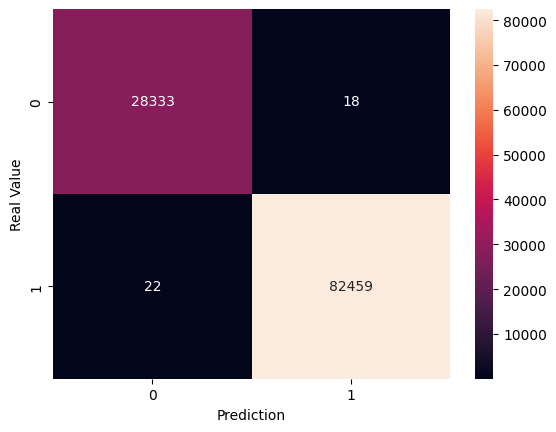

In [20]:
from sklearn.metrics import confusion_matrix

y_pred = model_ev.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_pred_classes, y_val)
sns.heatmap(cm, annot = True, fmt = "d", cmap = "rocket")

plt.xlabel("Prediction")
plt.ylabel("Real Value")
plt.show()